In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import StandardScaler
import func
import matplotlib.pyplot as plt

In [2]:
def network_1():
    # Input
    inputs = layers.Input(shape=(128, 128, 1), name="image_input")

    # Convert grayscale to 3 channels
    x = layers.Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)

    # Use ResNet50
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=x)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(30, activation="relu", name="latent_space")(x)

    return tf.keras.Model(inputs, outputs, name="ResNetImageNetwork")

def network_2():
    inputs = layers.Input(shape=(8,), name="npy_input")
    outputs = tf.keras.layers.Dense(10, activation="relu")(inputs)  # Joint embedding
    return tf.keras.Model(inputs, outputs, name="JointStateNetwork")

def combined_model():
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")
    npy_input = layers.Input(shape=(8,), name="npy_input")

    image_output = network_1()(image_input)
    npy_output = network_2()(npy_input)

    combined = layers.Concatenate()([image_output, npy_output])
    latent_space = layers.Dense(20, activation="relu", name="latent_space")(combined)

    return tf.keras.Model(inputs=[image_input, npy_input], outputs=latent_space, name="CombinedModel")

def create_decoder():
    latent_input = layers.Input(shape=(20,), name="latent_input")

    # Expand latent space to ... features
    expanded_features = layers.Dense(110, activation="relu")(latent_input)

    # Slice features for image and joint decoders
    image_features = layers.Lambda(lambda x: x[:, :100], name="image_features")(expanded_features)
    joint_features = layers.Lambda(lambda x: x[:, 100:], name="joint_features")(expanded_features)

    # Decode to image (Symmetric to network_1)
    latent_image = layers.Dense(100, name="latent_image")(image_features)

    # Tăng chiều từ embedding (30) lên kích thước phù hợp để reshape
    x_img = layers.Dense(8 * 8 * 64, activation="relu")(latent_image)  # Kích thước trung gian: 8x8x64
    x_img = layers.Reshape((8, 8, 64))(x_img)  # Reshape thành 8x8x64
    # Lần lượt dùng Conv2DTranspose và UpSampling2D để tăng dần kích thước
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (16, 16, 64)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (32, 32, 128)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (64, 64, 128)
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (128, 128, 64)
    # return (128, 128, 1)
    image_output = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same", name="reconstructed_image")(x_img)

    # Decode to joints (Symmetric to network_2)
    x_npy = layers.Dense(10, activation="relu")(joint_features)
    joint_output = layers.Dense(8, activation="linear", name="reconstructed_joint")(x_npy)

    return tf.keras.Model(inputs=latent_input, outputs=[image_output, joint_output], name="Decoder")

def downstream_task(pretrained_model_path="combine.weights.h5", freeze_up_to=None):
    # Load the pretrained model
    pretrained_model = combined_model()
    pretrained_model.load_weights(pretrained_model_path)

    # Freeze các lớp trong pretrained model (nếu cần)
    if freeze_up_to is not None:
        for layer in pretrained_model.layers[:-freeze_up_to]:
            layer.trainable = False

    # Input layers giống như mô hình đã pretrained
    image_input = pretrained_model.input[0]  # Input for images
    npy_input = pretrained_model.input[1]  # Input for joint state

    # Sử dụng output của pretrained model
    latent_space = pretrained_model.output

    # Thêm decoder
    decoder = create_decoder()
    image_output, joint_output = decoder(latent_space)

    # Tạo model mới
    downstream_model = tf.keras.Model(
        inputs=[image_input, npy_input],
        outputs=[image_output, joint_output],
        name="DownstreamModelWithDecoder"
    )
    return downstream_model


In [3]:
model = downstream_task()
model.load_weights("reconstruct.weights.h5")

In [4]:
# test data
folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

images = []
npy_file = []
for jpg_path, npy_path in file_pairs:
    images.append(func.read_jpg_files(jpg_path))
    npy_file.append(func.read_and_parse_npy_file(npy_path))

scaler = StandardScaler()

# Normalizing images
i1 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images]
# Normalize joints
n1 = scaler.fit_transform(npy_file)  # Joint data for training

# Create datasets
test_data = tf.data.Dataset.from_tensor_slices((i1, n1))
test_data_output = tf.data.Dataset.from_tensor_slices((i1, n1))

# Combine inputs and outputs into final datasets
test_ds = tf.data.Dataset.zip((test_data, test_data_output))\
            .batch(32).prefetch(tf.data.AUTOTUNE)\
            .shuffle(100, seed=42)


In [5]:
def process_joint(data, mode):
    data = tf.convert_to_tensor(data, dtype=tf.float64)  # Chuyển về tensor nếu cần

    if mode == 1:
        return tf.zeros_like(data)
    
    elif mode == 2:
        return tf.fill(data.shape, -2.0)
    
    elif mode == 3:
        mean_value = tf.reduce_mean(data)
        return tf.fill(data.shape, mean_value)
    
    
    else:
        raise ValueError(f"No mode")


In [23]:
# Visualize reconstructed images
for data, labels in test_ds.take(1):
    img_input = data[0]
    joint_input = data[1]
    true_img = labels[0]
    true_joint = labels[1]

    # Change joint to 'empty' it
    joint_input_1 = process_joint(joint_input,1)
    joint_input_2 = process_joint(joint_input,2)
    joint_input_3 = process_joint(joint_input,3)

    # Predict reconstructions
    pred_img_1, pred_joint = model.predict({"image_input": img_input, "npy_input": joint_input_1})
    pred_img_2, pred_joint = model.predict({"image_input": img_input, "npy_input": joint_input_2})
    pred_img_3, pred_joint = model.predict({"image_input": img_input, "npy_input": joint_input_3})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


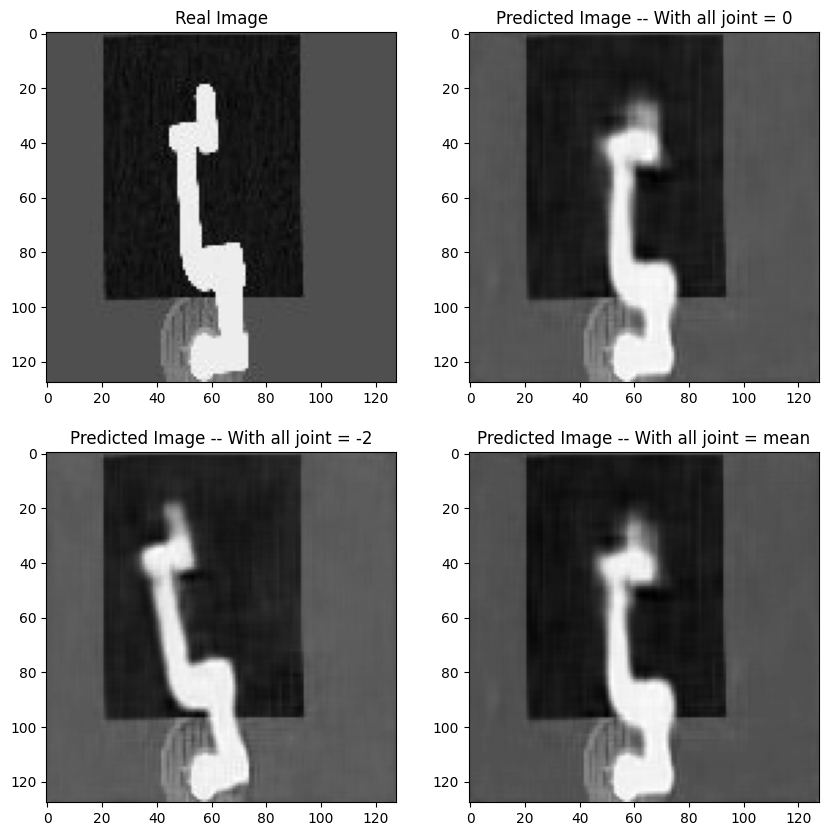

In [24]:
real_images = true_img.numpy()
predicted_images_1 = pred_img_1
predicted_images_2 = pred_img_2
predicted_images_3 = pred_img_3
# plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# True image
ax[0,0].imshow(real_images[0], cmap='gray')  
ax[0,0].set_title('Real Image')
ax[0,0].axis('on')

# Pred image
ax[0,1].imshow(predicted_images_1[0], cmap='gray')  
ax[0,1].set_title('Predicted Image -- With all joint = 0')
ax[0,1].axis('on') 

# Pred image
ax[1,0].imshow(predicted_images_2[0], cmap='gray')  
ax[1,0].set_title('Predicted Image -- With all joint = -2')
ax[1,0].axis('on')

# Pred image
ax[1,1].imshow(predicted_images_3[0], cmap='gray')  
ax[1,1].set_title('Predicted Image -- With all joint = mean')
ax[1,1].axis('on') 


plt.show()

In [35]:
def process_img(data, mode):
    data = tf.cast(data, dtype=tf.float32)  # Chuyển về tensor nếu cần

    if mode == 1:
        return tf.zeros_like(data)
    
    elif mode == 2:
        return tf.fill(data.shape, 70.0)
    
        # elif mode == 2:
    #     return tf.fill(data.shape, -2.0)
    
    
    elif mode == 3:
        mean_value = tf.reduce_mean(data)
        return tf.fill(data.shape, mean_value)
    
    else:
        raise ValueError(f"No mode")


In [36]:
# Visualize reconstructed images
for data, labels in test_ds.take(1):
    img_input = data[0]
    joint_input = data[1]
    true_img = labels[0]
    true_joint = labels[1]

    # Change joint to 'empty' it
    image_input_1 = process_img(img_input,1)
    image_input_2 = process_img(img_input,2)
    image_input_3 = process_img(img_input,3)
    # Change image to 'empty' it
    #img_input = 

    # Predict reconstructions
    pred_img_1, pred_joint = model.predict({"image_input": image_input_1, "npy_input": joint_input})
    pred_img_2, pred_joint = model.predict({"image_input": image_input_1, "npy_input": joint_input})
    pred_img_3, pred_joint = model.predict({"image_input": image_input_1, "npy_input": joint_input})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


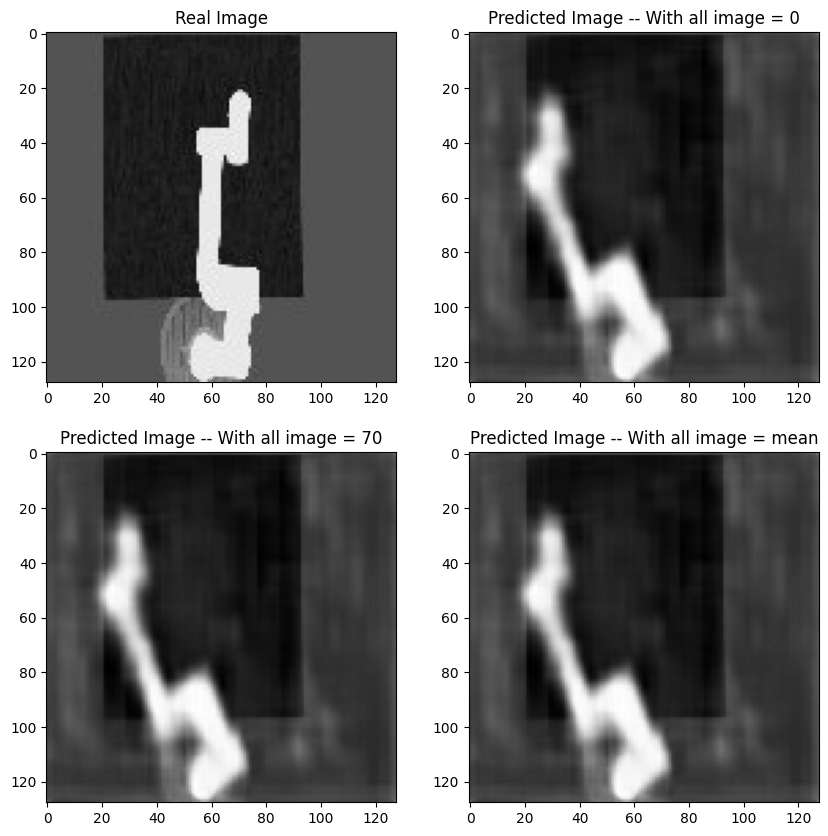

In [37]:
real_images = true_img.numpy()
predicted_images_1 = pred_img_1
predicted_images_2 = pred_img_2
predicted_images_3 = pred_img_3
# plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# True image
ax[0,0].imshow(real_images[0], cmap='gray')  
ax[0,0].set_title('Real Image')
ax[0,0].axis('on')

# Pred image
ax[0,1].imshow(predicted_images_1[0], cmap='gray')  
ax[0,1].set_title('Predicted Image -- With all image = 0')
ax[0,1].axis('on') 

# Pred image
ax[1,0].imshow(predicted_images_2[0], cmap='gray')  
ax[1,0].set_title('Predicted Image -- With all image = 70')
ax[1,0].axis('on')

# Pred image
ax[1,1].imshow(predicted_images_3[0], cmap='gray')  
ax[1,1].set_title('Predicted Image -- With all image = mean')
ax[1,1].axis('on') 


plt.show()